## HW10_zz1598
## Assignment 2

# Spatial Data Analysis - Seasonal Analysis
Exploratory spatial data analysis of CitiBike data(Summer and Winter) using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [3]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

In [7]:
if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
    os.environ['PUI2016'] = '/home/cusp/zz1598/PUI2016'
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")  
    os.environ['PUIDATA'] = '/home/cusp/zz1598/PUIdata'
    
print (os.environ['PUIDATA'] ) #print the path of desired directory PUIDATA

/home/cusp/zz1598/PUIdata


## Working with Shape File
Assume that the data has been downloaded in the **PUIdata/Data** folder <br/>
To download it, please fork the Github repository: https://github.com/fedhere/PUI2016_fb55 and then copy the **Data** foler to the PUIdata directory.

### Loading Census Tract Shape File¶

In [8]:
from geopandas import GeoDataFrame

shape_path="/Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(os.getenv("PUIDATA") + shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [9]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

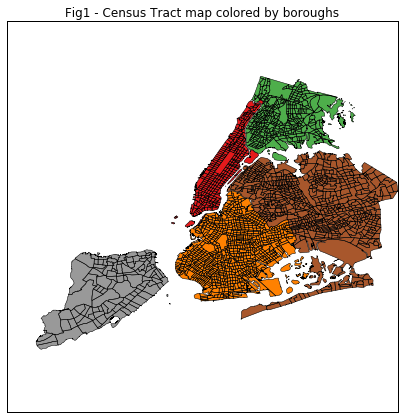

In [10]:
f, ax = plt.subplots(figsize=(7,7))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Fig1 - Census Tract map colored by boroughs")

**Figure 1**: The plot above demonstrates the 5 boroughs of NYC with Cencus Tract boundaries. This will give the reader a better idea about the differences of citi-bike riderships in different boroughs.

### Map NYC Population density

#### Load Census Data for 2010

In [11]:
ct_data=DataFrame.from_csv(os.getenv("PUIDATA") + '/Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

In [12]:
ct_data.head(3)

,BoroCT2010,Geo_NAME,Geo_QName,Geo_FIPS,Geo_SUMLEV,Geo_GEOCOMP,Geo_STATE,Geo_COUNTY,Geo_COUNTYSC,Geo_COUSUB,...,SE_T017_017,SE_T017_018,SE_T017_019,SE_T017_020,SE_T017_021,SE_T017_022,SE_T017_023,SE_T017_024,SE_T017A001,SE_T017A002
BoroCT2010,,,,,,,,,,,,,,,,,,,,,
5000900,5000900,Census Tract 9,"Census Tract 9, Richmond County, New York",36085000900,140,0,36,85,19,NaN,...,32,23,13,12,10,12,11,7,746,50
5012500,5012500,Census Tract 125,"Census Tract 125, Richmond County, New York",36085012500,140,0,36,85,19,NaN,...,50,50,28,33,36,32,42,20,1522,89
5013301,5013301,Census Tract 133.01,"Census Tract 133.01, Richmond County, New York",36085013301,140,0,36,85,19,NaN,...,0,11,6,3,15,4,4,4,303,24


#### Add popuation density to CT shapefile

In [13]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

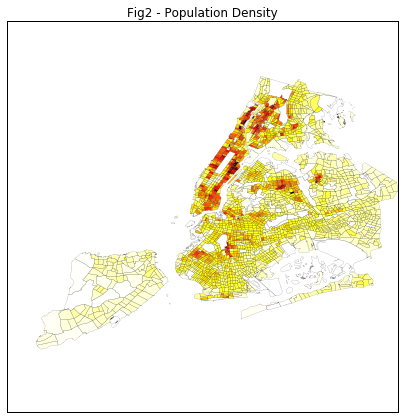

In [14]:
f, ax = plt.subplots(figsize=(7,7))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Fig2 - Population Density")

**Figure 2**: The monochropleth map shows the population density of NYC-- the darder the color the denser the population in that tract. This will help to interpret the relationship between ridership and the population density in the following analysis

## Explore CitiBike data

### Load CitiBike data

In [15]:
df_bike_monthly=DataFrame.from_csv(os.getenv("PUIDATA") + '/Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_bike_monthly.index

DatetimeIndex(['2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31',
               '2013-11-30', '2013-12-31', '2014-01-31', '2014-02-28',
               '2014-03-31', '2014-04-30', '2014-05-31', '2014-06-30',
               '2014-07-31', '2014-08-31', '2014-09-30', '2014-10-31',
               '2014-11-30', '2014-12-31', '2015-01-31', '2015-02-28',
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31', '2016-01-31', '2016-02-29',
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30'],
              dtype='datetime64[ns]', name=u'starttime', freq=None)

In [17]:
# Split the data set based on Summer and Winter months

#Summer
df_bike_summer = df_bike_monthly.ix[(0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 35), :]

df_bike_winter = df_bike_monthly.ix[(4, 5, 6, 7, 16, 17, 18, 19, 29, 30, 31, 32), :]

In [18]:
print (df_bike_summer.shape)
df_bike_summer.head(3)

(12, 543)


,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_bike_summer.index

DatetimeIndex(['2013-07-31', '2013-08-31', '2013-09-30', '2014-06-30',
               '2014-07-31', '2014-08-31', '2014-09-30', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2016-06-30'],
              dtype='datetime64[ns]', name=u'starttime', freq=None)

In [20]:
print (df_bike_winter.shape)
df_bike_winter.head(3)

(12, 543)


,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0


### Time Series Analysis

#### Seasonal Decomposition

                                   Fig3 - Seasonal Decomposition of Monthly Rides Data


/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


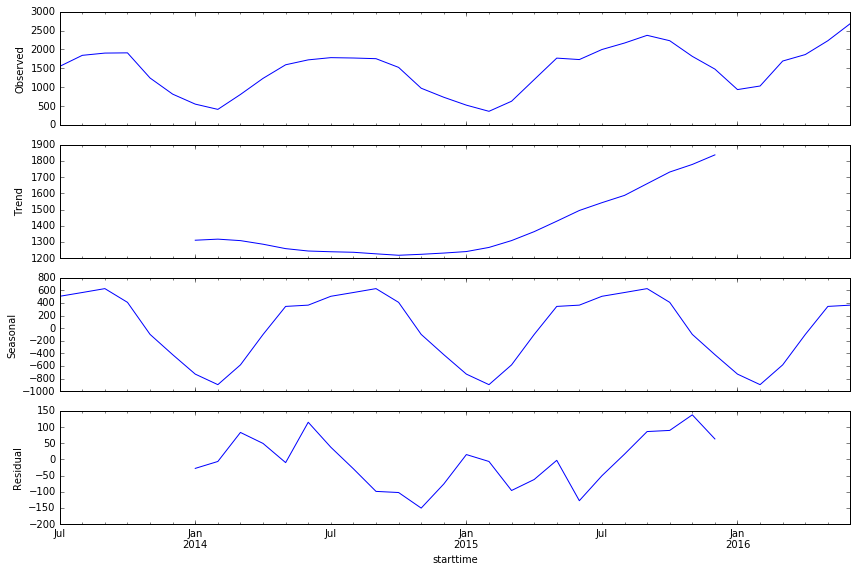

In [21]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()
print ('                                   \
Fig3 - Seasonal Decomposition of Monthly Rides Data')

**Figure 3**: The four subplots demonstrate the observed ridership data, trend of the data, seasonal fluctuation, and residual changes of the data with respect to time. It can be seen clearly that there is a cyclical seasonal pattern of the rides. Therefore, it is reasonable to split the data according to winter and summer months, perform analysis and compare the results.

#### Summer Rides Overview

(-200, 16000)

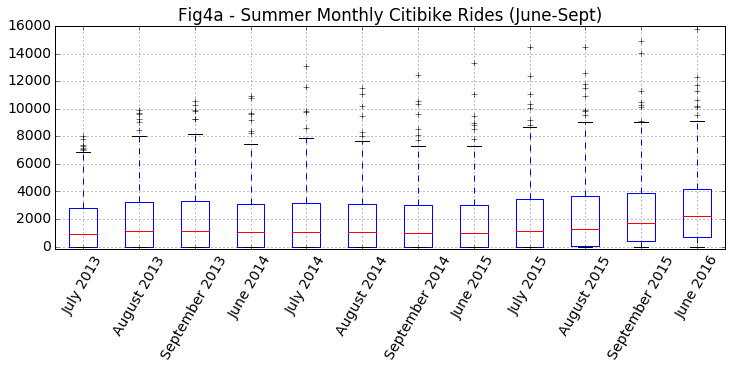

In [22]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(12,4))
#create a copy of the df for the viz purposes
df_bike_summer_=df_bike_summer.copy()
df_bike_summer_.index=df_bike_summer_.index.strftime("%B %Y")
df_bike_summer_.T.boxplot(figsize = (12,5),ax = ax,rot = 60, return_type='axes')
ax.set_title('Fig4a - Summer Monthly Citibike Rides (June-Sept)')
ax.set_ylim([-200,16000])

**Figure 4a**: The box plot shows the quartiles of the Citibike ride counts by station in selected summer months. For each of these months, the median rides of the stations are around 1000, where the highest ranges from 7000 to 9000.

#### Winter Rides Overview

(-200, 16000)

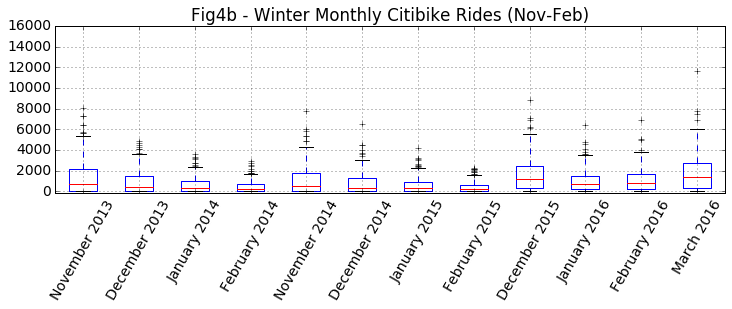

In [23]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(12,3))
#create a copy of the df for the viz purposes
df_bike_winter_=df_bike_winter.copy()
df_bike_winter_.index=df_bike_winter_.index.strftime("%B %Y")
df_bike_winter_.T.boxplot(figsize = (12,3),ax = ax,rot = 60, return_type = 'axes')
ax.set_title('Fig4b - Winter Monthly Citibike Rides (Nov-Feb)')
ax.set_ylim([-200,16000])

**Figure 4b**: The box plot shows the quartiles of the Citibike ride counts by station in selected winter months. For most of these months, the median rides of the stations are less than 1000, where the highest ranges from a little less than 1000 to 6000. 

Compared to the summer plot, there is a substantial drop of citibike rides in colder months.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [24]:
station_id=DataFrame.from_csv(os.getenv('PUIDATA') + '/Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [25]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [26]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [30]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

#### ---Summer---

In [31]:
### Create the sum of monthly rides column from summer monthly citibike data -- sum by station id
## add it to the station id which has the geometry
station_id['SummerAve']=df_bike_summer.sum()

#### ---Winter---

In [32]:
### Create the sum of monthly rides rides column from winter monthly citibike data -- sum by station id
## add it to the station id which has the geometry
station_id['WinterAve']=df_bike_winter.sum()

In [33]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,SummerAve,WinterAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,30696,14667
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,45966,19148
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,118837,56628
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,44794,21484
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,82749,35745


### Add the Summer and Winter monthly average rides to the CT shapefile 

In [34]:
# Create a dataframe "temp" with summer and winter rides with corresponding station id and borough id
temp=station_id.ix[:,('SummerAve', 'WinterAve')]
temp.reset_index(inplace=True)
temp.rename(columns = {'index':'Station_id'}, inplace = True)
temp.index = station_id['BoroCT2010']
temp.head(3)

,Station_id,SummerAve,WinterAve
BoroCT2010,,,
1009000,1000,30696,14667
1009900,1001,45966,19148
1005700,1002,118837,56628


In [35]:
# join temp and ct_shape
ct_shape_sumwinAve=ct_shape.join(temp)
ct_shape_sumwinAve.fillna(0,inplace=True)
ct_shape_sumwinAve.head(2)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Station_id,SummerAve,WinterAve
BoroCT2010,,,,,,,,,,,,,,,
1000100,1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0,0.0,0.0
1000201,1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0,0.0,0.0


#### -- Summer Ride Map--

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


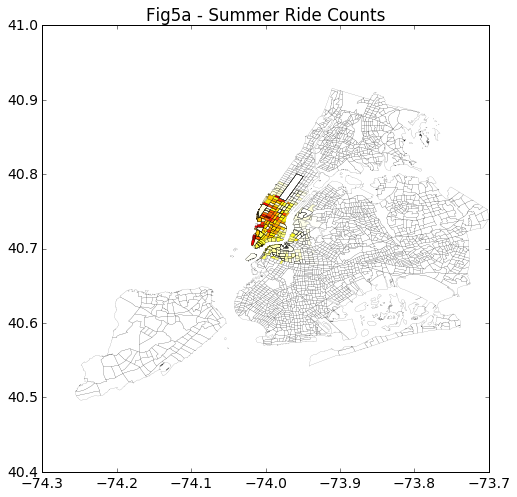

In [36]:
f, ax = plt.subplots(figsize=(8,8))
ct_shape_sumwinAve.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Fig5a - Summer Ride Counts")

**Figure 5a**: A glance of the density of summer citibike rides in the boroughs.

#### --Winter Ride Map--

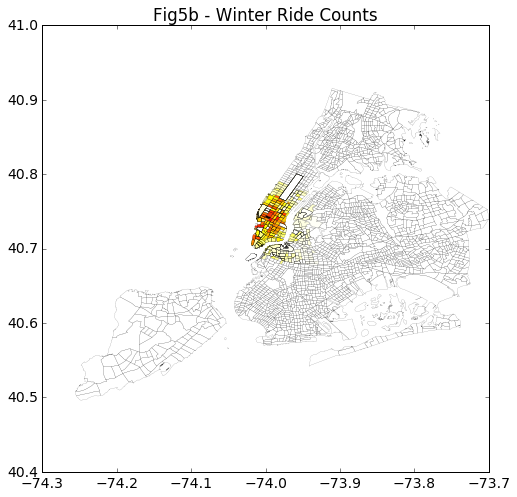

In [37]:
f, ax = plt.subplots(figsize=(8,8))
ct_shape_sumwinAve.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Fig5b - Winter Ride Counts")

**Figure 5b**: A glance of the density of winter citibike rides in the boroughs.

### Removing the CTs that are out of zoom boundries

In [38]:
# Zoom in the map and keep only the study areas
ct_shape_sumwinAve_Zoom=(ct_shape_sumwinAve[ct_shape_sumwinAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [39]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed Summer CTs:", len(temp.SummerAve)
print "Number of zoomed Winter CTs:", len(temp.WinterAve)

Total number of CTs: 2166
Number of zoomed Summer CTs: 543
Number of zoomed Winter CTs: 543


### Map the Summer and Winter rides 

#### --Summer Zoomin Map--

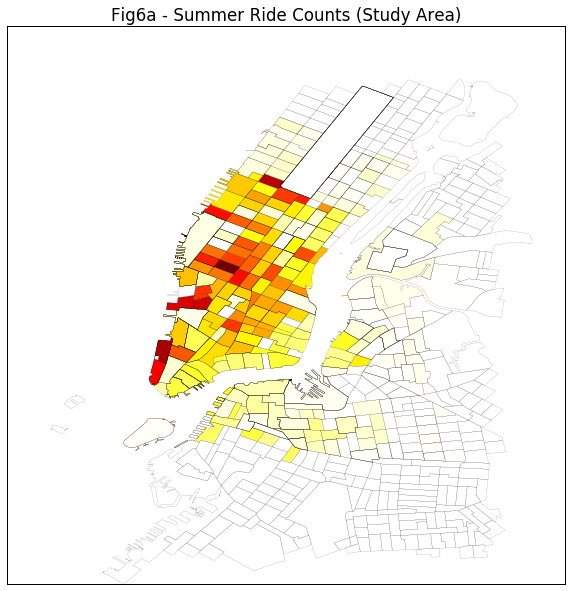

In [40]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_sumwinAve_Zoom.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Fig6a - Summer Ride Counts (Study Area)")

**Figure 6a**: A zoomin view of the density of summer citibike rides in the study area. Darker color means more rides. It can be observed that Midtown and Downtown West in Manhattan has more riderships than other areas.

#### --Winter--

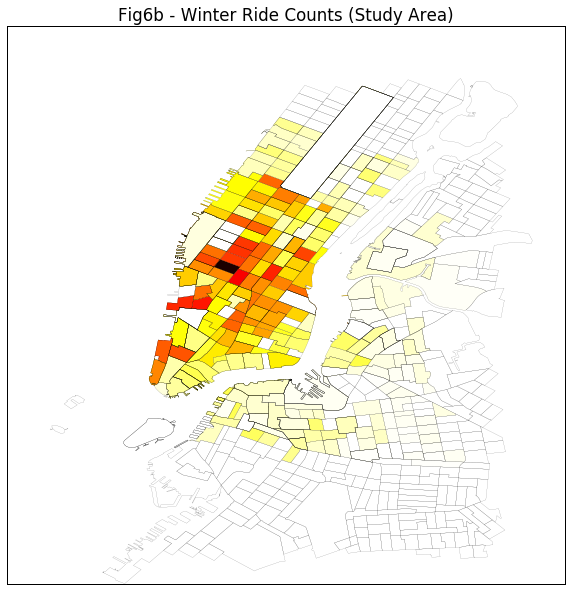

In [41]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_sumwinAve_Zoom.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Fig6b - Winter Ride Counts (Study Area)")

**Figure 6b**: A zoomin view of the density of winter citibike rides in the study area. Darker color means more rides. It can be observed that Midtown and Downtown West in Manhattan have more riderships than other areas.

Compared to the summer rides map(figure 6a), the colors are a level lighter for winter, which indicates a generally lower ridership in winter. The overall ridership pattern based on locations in both maps are similar.

### Export Shapefile CTs in the CitiBike Zone

In [42]:
# Check if the Output directory exists. If not, then create one
if not os.path.isdir(os.getenv('PUIDATA') + '/Output'):
    os.system('mkdir ' + os.getenv('PUIDATA') + '/Output')

In [43]:
# export the zoomed study area as a shape file for use
path = os.getenv('PUIDATA') + '/Output/ct_shape_sumwinAve_Zoom.shp'   
ct_shape_sumwinAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [44]:
import pysal as ps

In [45]:
ps.version #Check verison. The version needs to be 1.12 to correctly run ps.Moran_Local

'1.12.0'

### Spatial Weights
Contiguity: Queen Weights 
-- Queen contiguity defines as neighbors any pair of polygons that share at
least one vertex in their polygon definitions

In [46]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [47]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [48]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [49]:
Wmatrix, ids = qW_CT.full()

In [50]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [51]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be mesured by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [52]:
## Calculate the spatial lag by adding neiboughers's weights to the summer rides
SummerRide=ct_shape_sumwinAve_Zoom.SummerAve
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)

In [53]:
## Calculate the spatial lag by adding neiboughers's weights to the winter rides
WinterRide=ct_shape_sumwinAve_Zoom.WinterAve
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)

#### Create Quantiles for maping

In [54]:
# Summer
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
SummerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    88.000                 2
   88.000 < x[i] <=  1511.625                78
 1511.625 < x[i] <=  3075.000                80
 3075.000 < x[i] <=  7551.400                81
 7551.400 < x[i] <= 11627.857                78
11627.857 < x[i] <= 25693.803                79
25693.803 < x[i] <= 37395.214                80
37395.214 < x[i] <= 43198.655                79
43198.655 < x[i] <= 66036.500                80

In [55]:
# Winter
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    55.143                 2
   55.143 < x[i] <=   921.917                78
  921.917 < x[i] <=  2284.412                80
 2284.412 < x[i] <=  3603.582                79
 3603.582 < x[i] <=  5241.300                80
 5241.300 < x[i] <= 12088.429                79
12088.429 < x[i] <= 16528.714                80
16528.714 < x[i] <= 19867.643                79
19867.643 < x[i] <= 32048.714                80

#### Map the Summer rides lag

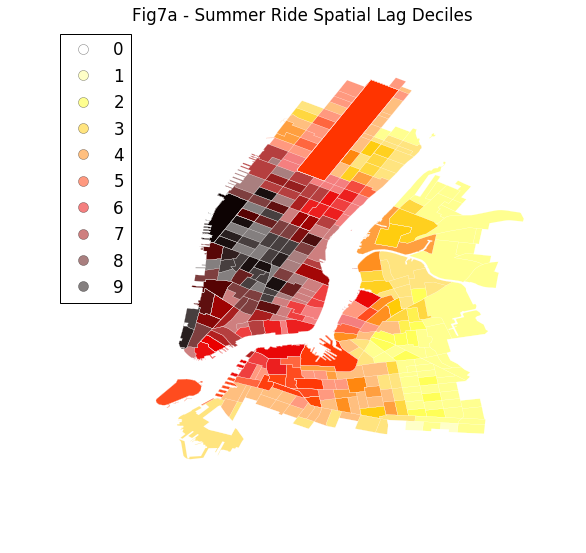

In [56]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_sumwinAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Fig7a - Summer Ride Spatial Lag Deciles")

**Figure 7a**: The map shows the study area that is colored based on 10 quantiles of **summer** ride spatial lag. Darker color indicates larger rideships of the spatial lag quantile.

#### Map the Winter rides lag

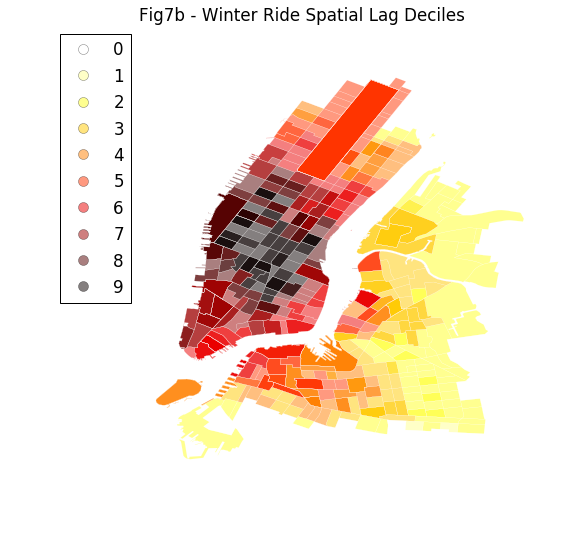

In [57]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_sumwinAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Fig7b - Winter Ride Spatial Lag Deciles")

**Figure 7b**: The map shows the study area that is colored based on 10 quantiles of **winter** ride spatial lag. Darker color indicates larger rideships of the spatial lag quantile.

Compared to the summer map(figure 8a), the overall pattern is similar, but is lighter in general.

## Global  Spatial Autocorrelation

In [58]:
# Summer
b1,a1 = np.polyfit(SummerRide, SummerRideLag, 1)
b1,a1 

(0.6438931431258913, 5682.9310787418508)

In [59]:
# Winter
b2,a2 = np.polyfit(WinterRide, WinterRideLag, 1)
b2,a2

(0.66015595797276572, 2519.1088385719627)

### Moran Scatterplot

(array([      0.,   20000.,   40000.,   60000.,   80000.,  100000.,  120000.]),
 <a list of 7 Text xticklabel objects>)

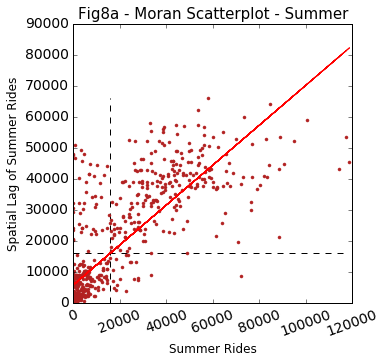

In [60]:
# Summer plot
f, ax = plt.subplots(1, figsize = (5, 5))

plt.plot(SummerRide, SummerRideLag, '.', color = 'firebrick')

# dashed vertical at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle = '--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a1 + b1 * SummerRide, 'r')
plt.title('Fig8a - Moran Scatterplot - Summer', size = 15)
plt.ylabel('Spatial Lag of Summer Rides', size = 12)
plt.xlabel('Summer Rides', size = 12)
plt.xticks(rotation = 20)

**Figure 8a**: The map shows the correlation between summer rides and summer rides spatial lag with a fitted line.
The dotted PCI lines divide the areas into four where the top right area contains the **hot spot** data points and bottom left are **cold spot** data points.

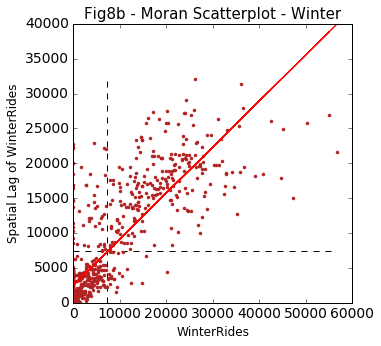

In [61]:
# Winter Plot
f, ax = plt.subplots(1, figsize=(5, 5))

plt.plot(WinterRide, WinterRideLag, '.', color = 'firebrick')

 # dashed vertical at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle = '--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a2 + b2 * WinterRide, 'r')
plt.title('Fig8b - Moran Scatterplot - Winter', size = 15)
plt.ylabel('Spatial Lag of WinterRides', size = 12)
plt.xlabel('WinterRides', size = 12)

**Figure 8b**: The map shows the correlation between winter rides and winter rides spatial lag with a fitted line.
The dotted PCI lines divide the areas into four where the top right area contains the **hot spot** data points and bottom left are **cold spot** data points.

### Moran's I

In [62]:
# Moran's I for summer rides
I_SummerRide = ps.Moran(SummerRide, qW_CT)

In [63]:
I_SummerRide.I, I_SummerRide.p_sim  # significant: 0.001

(0.6440694990680973, 0.001)

Thus, the $I$ statistic is $0.644$ for the summer data, and has a very small $p$ value. 

In [64]:
# Simulation points
I_SummerRide.sim[0:10]

array([ 0.02314033, -0.01497826, -0.0239101 ,  0.00799516, -0.0115507 ,
        0.00757015,  0.00575335, -0.0120716 ,  0.00563636,  0.00349351])

In [65]:
# Moran's I for winter rides
I_WinterRide = ps.Moran(WinterRide, qW_CT)
I_WinterRide.I, I_WinterRide.p_sim  # significant: 0.001

(0.66031605431349316, 0.001)

Thus, the $I$ statistic is $0.660$ for the winter data, and has a very small $p$ value. 

In [66]:
# Simulation points
I_WinterRide.sim[0:10]

array([ 0.01720187,  0.0091334 ,  0.02132744,  0.0004797 , -0.02195018,
        0.00749942,  0.00426436, -0.00398752, -0.00244456, -0.01747202])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [67]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

#### KDE Simulation for Summer Rides

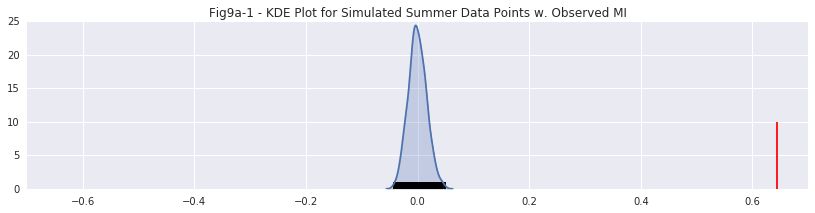

In [68]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('Fig9a-1 - KDE Plot for Simulated Summer Data Points w. Observed MI')

**Figure 9a-1**: Bell shaped simulated data points of summer rides versus the red vertical line--the observed value of Moran's I. (See more explanation below)

#### In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

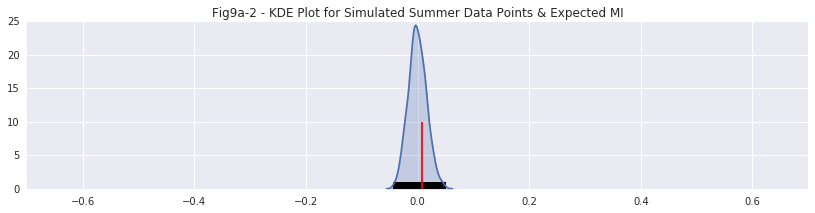

In [69]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('Fig9a-2 - KDE Plot for Simulated Summer Data Points & Expected MI')

**Figure 9a-2**: Bell shaped simulated data points of summer rides with the red vertical line--the expected value of Moran's I under normality assumption. 

The observed value for I is significantly above its expected value, under the assumption of normality for the summer rides.

### KDE Simulation for Winter Rides

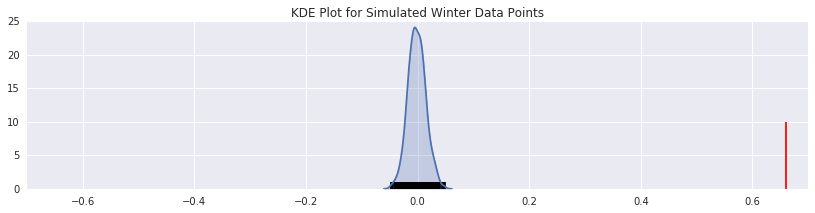

In [70]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDE Plot for Simulated Winter Data Points')

**Figure 9b-1**: Bell shaped simulated data points of winter rides with the red vertical line--the observed value of Moran's I under normality assumption. 

#### In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

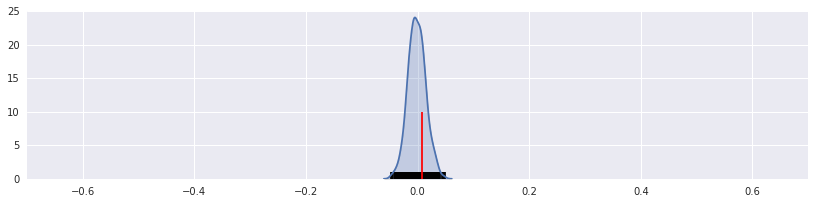

In [71]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

**Figure 9b-2**: Bell shaped simulated data points of winter rides with the red vertical line--the expected value of Moran's I under normality assumption. 

The observed value for I is significantly above its expected value, under the assumption of normality for the winter rides.

## Local  Spatial Autocorrelation

### Local Moran for Summer Rides

In [72]:
## Summer
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT, permutations = 999)

In [73]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.23689404,  0.01179723,  0.00235718,  0.0247348 ]),
 array([ 0.001,  0.168,  0.388,  0.363,  0.38 ]))

In [74]:
# p_sim: p-values based on permutations (one-sided)
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.23689404,  0.01179723,  0.00235718,  0.0247348 ]),
 array([ 0.001,  0.168,  0.388,  0.363,  0.38 ]))

### Local Moran for Winter Rides

In [75]:
## Winter
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT, permutations = 999)

In [76]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.29831742, -0.00135215, -0.00111041, -0.05456961]),
 array([ 0.001,  0.149,  0.472,  0.46 ,  0.433]))

In [77]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.29831742, -0.00135215, -0.00111041, -0.05456961]),
 array([ 0.001,  0.149,  0.472,  0.46 ,  0.433]))

### LISA (Local Indicators of Spatial Autocorrelation)

#### Summer

In [81]:
# Classify significant and non-significant rides based on value of Local Moran
sigs1 = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs1 = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs1 = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs1 = SummerRideLag[LMo_SummerRide.p_sim > .001]

#### Winter

In [82]:
sigs2 = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs2 = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs2 = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs2 = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

#### Summer

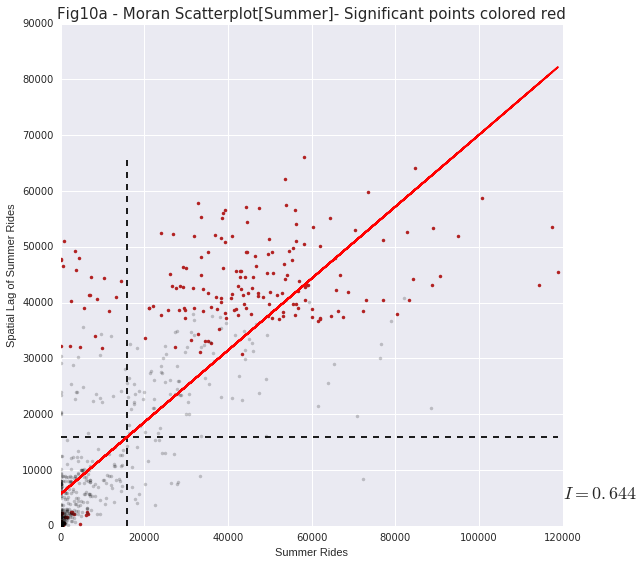

In [87]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs1, W_sigs1, '.', color='firebrick')
plt.plot(insigs1, W_insigs1, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_SummerRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a1 + b1 * SummerRide, 'r')
plt.title('Fig10a - Moran Scatterplot[Summer]- Significant points colored red', size = 15)
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')


**Figure 10a**: The plot demonstrates the **spatial lag of summer rides** versus the **summer rides** data points with a fitted line. The significant rides as colored as red while the insignificant ones are colred as light grey based on Local Moran's p-values.

#### Winter

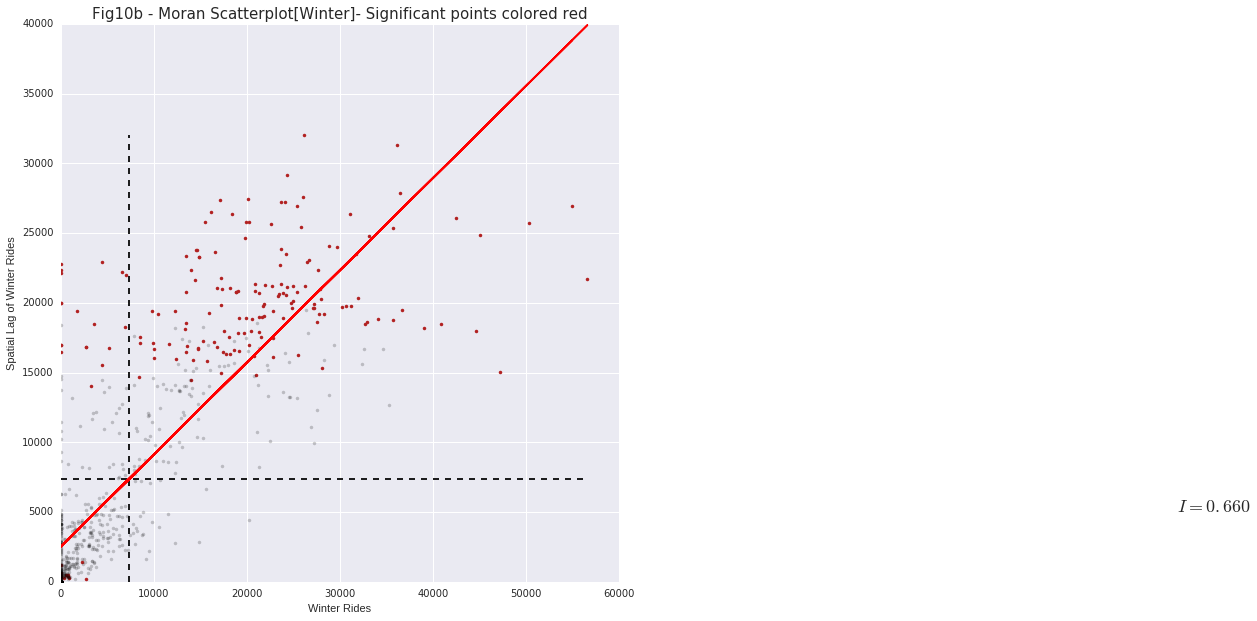

In [88]:
f, ax = plt.subplots(figsize=(10, 10))
plt.plot(sigs2, W_sigs2, '.', color='firebrick')
plt.plot(insigs2, W_insigs2, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_WinterRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a2 + b2 * WinterRide, 'r')
plt.title('Fig10b - Moran Scatterplot[Winter]- Significant points colored red', size = 15)
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

**Figure 10b**: The plot demonstrates the **spatial lag of winter rides** versus the **winter rides** data points with a fitted line. The significant rides as colored as red while the insignificant ones are colred as light grey based on Local Moran's p-values.

### Hot and Cold spots 

#### Summer

In [90]:
sig1 = LMo_SummerRide.p_sim < 0.01
hotspots1 = LMo_SummerRide.q==1 * sig1
coldspots1 = LMo_SummerRide.q==3 * sig1
print "Number of Summer Ride Hotspots:", hotspots1.sum()
print "Number of Summer Ride Coldspots:", coldspots1.sum()

Number of Summer Ride Hotspots: 189
Number of Summer Ride Coldspots: 247


#### Winter

In [98]:
sig2 = LMo_WinterRide.p_sim < 0.01
hotspots2 = LMo_WinterRide.q==1 * sig1
coldspots2 = LMo_WinterRide.q==3 * sig1
print "Number of Winter Ride Hotspots:", hotspots2.sum()
print "Number of Winter Ride Coldspots:", coldspots2.sum()

Number of Winter Ride Hotspots: 190
Number of Winter Ride Coldspots: 246


### Heat Maps of Hot and Cold Spots for Summer and Winter Rides

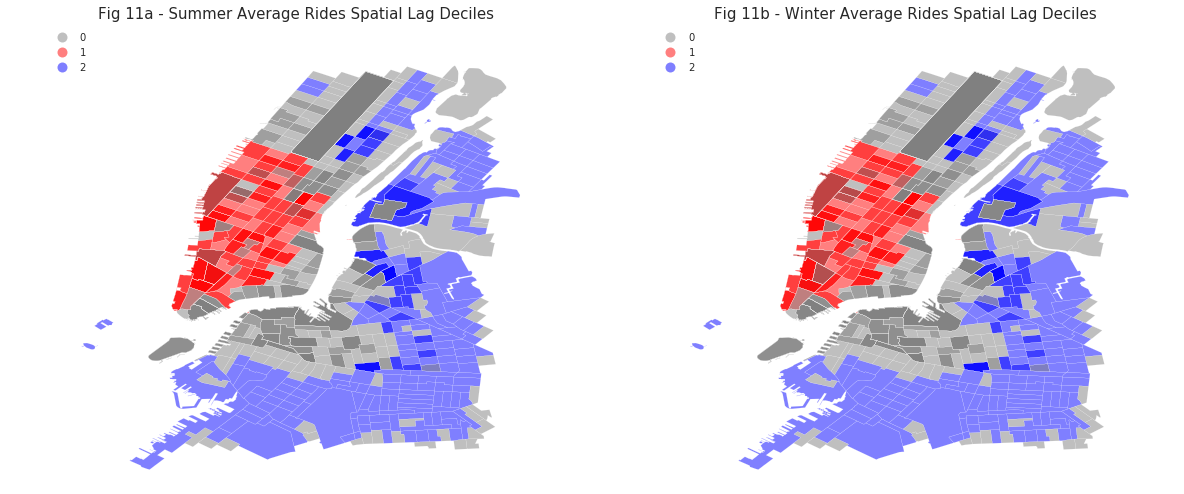

In [115]:
from matplotlib import colors

# Summer
hcmap1 = colors.ListedColormap(['grey','red','blue'])
hotcold1 = hotspots1 * 1 + coldspots1 * 2
# Winter
hcmap2 = colors.ListedColormap(['grey','red','blue'])
hotcold2 = hotspots2 * 1 + coldspots1 * 2


fig = plt.figure(figsize = (20, 8))

ax1 = fig.add_subplot(121)
ct_shape_sumwinAve_Zoom.assign(cl=hotcold1).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap1, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
plt.title("Fig 11a - Summer Average Rides Spatial Lag Deciles", size=15)

ax2 = fig.add_subplot(122)
ct_shape_sumwinAve_Zoom.assign(cl=hotcold2).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap2, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_axis_off()
plt.title("Fig 11b - Winter Average Rides Spatial Lag Deciles", size = 15)

**Figure 11a & 11b**: The heat maps show the hot spots and cold spots of summer and winter rides based on Moran's I Statistics(Local). Auto-correlation occurs in both maps in a similar manner, indicated by the similar color patterns. This shows that although the ride counts in summer months are higher than that of winter months, the relationships between the ridership within a borough tract and its neighbour tracts have a similar pattern for both categories (Neighbours are weighted)

**Similarity--** Hot spots concentrate in downtown and midtown west Manhattan areas; <br/>
cold spots are mostly observed in uptown east Manhattan, Long Island City(Queens), and outter Brooklyn areas that have some distance from Manhattan. 

**Difference--** There are slight differences in certain tract areas where the level of autocorrelation are not the same.